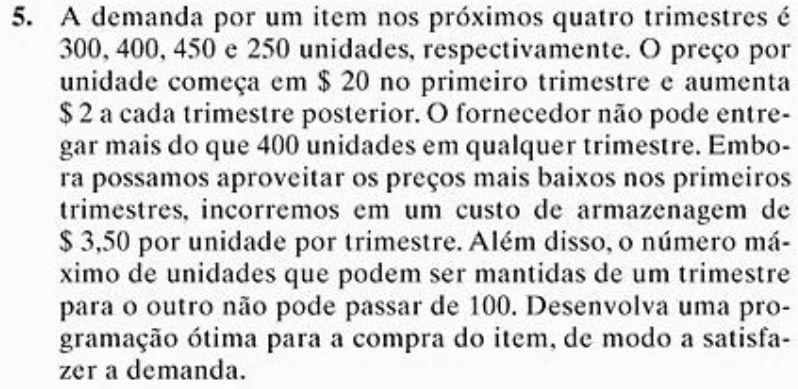

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Planejamento_Compras_Trimestral')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Períodos de tempo
trimestres = [1, 2, 3, 4]

# Demanda trimestral (em unidades)
demanda_trimestral = {1: 300, 2: 400, 3: 450, 4: 250}

# Custos
preco_por_unidade = {1: 20, 2: 22, 3: 24, 4: 26}
custo_armazenagem_unidade_trimestre = 3.50

# Limites
limite_compra_trimestral = 400 # unidades
limite_estoque_trimestral = 100 # unidades

In [4]:
# 1. Variáveis de Decisão
# Quantidade de unidades compradas em cada trimestre
compras = model.continuous_var_dict(trimestres, name='Compra')

# Quantidade de unidades em estoque no final de cada trimestre
estoque_final = model.continuous_var_dict(trimestres, name='Estoque', lb=0)


# 2. Função Objetivo
# Minimizar o custo total (Compras + Armazenagem)
expressao_custo_compra = (preco_por_unidade[t] * compras[t] for t in trimestres)
soma_custo_compra = model.sum(expressao_custo_compra)

expressao_custo_estoque = (custo_armazenagem_unidade_trimestre * estoque_final[t] for t in trimestres)
soma_custo_estoque = model.sum(expressao_custo_estoque)

custo_total = soma_custo_compra + soma_custo_estoque
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Balanço de Estoque para cada trimestre
# Estoque_Inicial + Compras - Demanda = Estoque_Final
for t in trimestres:
    estoque_inicial_trimestre = estoque_final[t-1] if t > 1 else 0
    restr_balanco_logica = estoque_inicial_trimestre + compras[t] - demanda_trimestral[t] == estoque_final[t]
    model.add_constraint(restr_balanco_logica, ctname=f'balanco_t{t}')

# Restrição 2: Limites de Compra e Estoque
for t in trimestres:
    # Limite de compra do fornecedor
    restr_limite_compra_logica = compras[t] <= limite_compra_trimestral
    model.add_constraint(restr_limite_compra_logica, ctname=f'limite_compra_t{t}')

    # Limite de capacidade de armazenagem
    restr_limite_estoque_logica = estoque_final[t] <= limite_estoque_trimestral
    model.add_constraint(restr_limite_estoque_logica, ctname=f'limite_estoque_t{t}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
custo_minimo = model.objective_value
print(f"Custo Total Mínimo para os quatro trimestres: ${custo_minimo:,.2f}\n")

print("--- Plano de Compras (unidades por trimestre) ---")
for t in trimestres:
    compra_val = compras[t].solution_value
    print(f"  - Trimestre {t}: {compra_val:,.2f} unidades")

print("\n--- Nível de Estoque (unidades no final do trimestre) ---")
for t in trimestres:
    estoque_val = estoque_final[t].solution_value
    print(f"  - Final do Trimestre {t}: {estoque_val:,.2f} unidades")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 12 rows and 8 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01 ticks)

------ SOLUÇÃO ÓTIMA ------

Custo Total Mínimo para os quatro trimestres: $32,250.00

--- Plano de Compras (unidades por trimestre) ---
  - Trimestre 1: 350.00 unidades
  - Trimestre 2: 400.00 unidades
  - Trimestre 3: 400.00 unidades
  - Trimestre 4: 250.00 unidades

--- Nível de Estoque (unidades no final do trimestre) ---
  - Final do Trimestre 1: 50.00 unidades
  - Final do Trimestre 2: 50.00 unidades
  - Final do Trimestre 3: 0.00 unidades
  - Final do Trimestre 4: 0.00 unidades
